In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import locale
import re
import ssl
import time
import warnings
from datetime import datetime, timedelta

import certifi
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm, tqdm_notebook
from transliterate import translit
from yandex_geocoder import Client
from scipy.stats import chi2_contingency

from src.eda_fun import fill_mode_group_by, parse_date, calculate_announcement_age, check_normal, cramers_v

warnings.filterwarnings("ignore")

os.chdir("..")

RAND = 10

In [2]:
df = pd.read_csv("data/data.csv", index_col=0)
df.rename(columns={"0": "link"}, inplace=True)

## EDA Analysis

As a result of the parsing, we have a data set with the following structure

#### Description of the features in the data set

- link - link to the ad  
- price - price of the flat  
- district_value - district  
- address_value - address  
- house_type_value - house type  
- apartment_type - apartment type  
- window_side - window side  
- renovation - renovation 
- area_documents - area according to documents  
- floor - floor of the apartment and floor of the building  
- balcony_loggia - availability of balcony/loggia  
- construction_status - status of building completed/uncompleted  
- mortgage - mortgage 
- description - description1  
- description2 - description2  
- year - Year of construction  
- data - date of announcement

On the basis of this data set, we will build a model for predicting the price of an apartment. Target variable **'price'**. In the first stage, the EDA analysis is performed.

The purpose of EDA (Exploratory Data Analysis) is to gain a deeper understanding of the structure, characteristics and relationships of the data for the subsequent modeling stage.The analysis includes the following steps:

1. **Preliminary review of the data set and assessment of data quality:** Examine the format, types and distribution of the data, identify the presence of outliers and anomalies. Search for outliers, errors and inconsistencies, assess the need for cleaning and transformation.
2. **Transform features and create new features:** 1.
2. **Discover dependencies and patterns:** Determine correlations and interactions between features, test hypotheses.

4. **Prepare for modeling:** Obtain information useful for selecting features, methods, and model parameters.

EDA serves as a first step to formulate hypotheses, adjust data, and develop strategies to achieve accurate and reliable results in subsequent analysis or model building.

## Preliminary dataset review and data quality assessment

In [3]:
# output the first five rows of the dataset
df[:5]

,link,price,district_value,address_value,house_type_value,apartment_type,window_side,renovation,area_documents,floor,balcony_loggia,construction_status,mortgage,description,description2,year,data
0,https://www.farpost.ru/nakhodka/realty/sell_fl...,1499000.0,Рыбный порт,проспект Находкинский 78,кирпичный,Доля,"восток, юг",Без ремонта,"40,0 кв. м. (доля 1/2)",4-й в 5-этажном здании,Нет,Дом сдан,Подходит под ипотеку,"[<p class=""inplace auto-shy"" data-field=""realt...","Доля в двухкомнатной квартире, второй собствен...",1963,10 сентября
1,https://www.farpost.ru/nakhodka/realty/sell_fl...,2500000.0,Заводская,улица Нахимовская 35,кирпичный,Доля,"запад, восток",NaN,"45,0 кв. м. (доля 3/4)",1-й в 5-этажном здании,Есть,Дом сдан,NaN,"[<p class=""inplace auto-shy"" data-field=""realt...",Предлагаю приобрести долю в праве общей долево...,1987,10 сентября
2,https://www.farpost.ru/nakhodka/realty/sell_fl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,1981,NaN
3,https://www.farpost.ru/nakhodka/realty/sell_fl...,500000.0,Гагарина (Третий участок),улица Добролюбова 5,монолитный,Доля,юг,Косметический,"42,2 кв. м. (доля 1/4)",1-й в 4-этажном здании,Нет,Дом сдан,Не подходит под ипотеку,"[<p class=""inplace auto-shy"" data-field=""realt...","жилое состояние, комнаты смежные, железная две...",1961,28 сентября 2023
4,https://www.farpost.ru/nakhodka/realty/sell_fl...,4640000.0,Мор. училище,улица Тимирязева 1а,кирпичный,Доля,NaN,Евроремонт,"108,4 кв. м. (доля 1/2)",4-й в 10-этажном здании,Есть,Дом сдан,NaN,"[<p class=""inplace auto-shy"" data-field=""realt...",Продаётся доля в уютной и просторной 3-комнатн...,1994,19 сентября 2023


In [4]:
# Print the size of the dataset
df.shape

(23732, 17)

In [5]:
# You can see from the first lines that not all ads were parsed, 
# because they weren't published at the time of parsing.
# Remove empty lines with no price
df.dropna(subset=["price"], inplace=True)
df.shape

(22854, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22854 entries, 0 to 23731
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   link                 22854 non-null  object 
 1   price                22854 non-null  float64
 2   district_value       22518 non-null  object 
 3   address_value        22851 non-null  object 
 4   house_type_value     17285 non-null  object 
 5   apartment_type       22854 non-null  object 
 6   window_side          6741 non-null   object 
 7   renovation           16127 non-null  object 
 8   area_documents       22793 non-null  object 
 9   floor                22501 non-null  object 
 10  balcony_loggia       15111 non-null  object 
 11  construction_status  22854 non-null  object 
 12  mortgage             14469 non-null  object 
 13  description          22854 non-null  object 
 14  description2         22702 non-null  object 
 15  year                 10514 non-null  obje

In [7]:
print("Number of omissions by column in percent:")
round(df.isnull().mean() * 100, 2)

Number of omissions by column in percent:


link                    0.00
price                   0.00
district_value          1.47
address_value           0.01
house_type_value       24.37
apartment_type          0.00
window_side            70.50
renovation             29.43
area_documents          0.27
floor                   1.54
balcony_loggia         33.88
construction_status     0.00
mortgage               36.69
description             0.00
description2            0.67
year                   53.99
data                    0.00
dtype: float64

In [8]:
df.nunique()

link                   22854
price                   7064
district_value           331
address_value           5462
house_type_value           6
apartment_type            10
window_side               16
renovation                 7
area_documents          1397
floor                    467
balcony_loggia             2
construction_status        2
mortgage                   2
description            12037
description2           11790
year                     162
data                    1429
dtype: int64

In [9]:
df.iloc[:, :].describe()

,price
count,2.285400e+04
mean,8.218645e+06
std,1.540490e+07
min,1.500000e+05
25%,5.597368e+06
50%,7.179900e+06
75%,9.378046e+06
max,2.200000e+09


In [10]:
# The price in one of the ads has an abnormally high value.
df_max = df[(df["price"] >= 2.200000e09)]
df_max

,link,price,district_value,address_value,house_type_value,apartment_type,window_side,renovation,area_documents,floor,balcony_loggia,construction_status,mortgage,description,description2,year,data
17301,https://www.farpost.ru/khabarovsk/realty/sell_...,2.200000e+09,Индустриальный,улица Краснореченская 125Подробности о доме,кирпичный,Доля,"запад, восток",Без ремонта,"81,9 кв. м. (доля 1/3)",1-й в 2-этажном здании,Нет,Дом сдан,Подходит под ипотеку,"[<p class=""inplace auto-shy"" data-field=""realt...","Продам! комнату в 3км квартире, в собственност...",1957,5 сентября


In [11]:
# Let's delete this line
df.drop(df[df["price"] >= 2.200000e09].index, inplace=True)

df = df.reset_index(drop=True)  # пересоздаем индексы после удаления строк

In [12]:
df.iloc[:, :].describe()

,price
count,2.285300e+04
mean,8.122737e+06
std,5.205189e+06
min,1.500000e+05
25%,5.597368e+06
50%,7.179900e+06
75%,9.376076e+06
max,1.400000e+08


In [13]:
columns = [
    "district_value",
    "address_value",
    "house_type_value",
    "apartment_type",
    "window_side",
    "renovation",
    "area_documents",
    "floor",
    "balcony_loggia",
    "construction_status",
    "mortgage",
    "year",
    "data",
]
df[columns].describe(include=["object", "bool"])

,district_value,address_value,house_type_value,apartment_type,window_side,renovation,area_documents,floor,balcony_loggia,construction_status,mortgage,year,data
count,22517,22850,17284,22853,6740,16126,22792,22500,15110,22853,14468,10513,22853
unique,331,5461,6,10,16,7,1396,467,2,2,2,162,1429
top,"64, 71 микрорайоны",улица Зеленый бульвар 2,монолитный,2-комнатная,запад,Косметический,"69,6 кв. м.",5-й в 5-этажном здании,Есть,Не сдан,Подходит под ипотеку,2023,16 сентября
freq,2628,730,8414,8000,1172,4813,257,845,10759,11603,14182,469,845


## Convert Features and Create New Features.
The purpose of this section is to put the values into a more convenient format and convert them into a form that can be entered into the model.

In [14]:
df = df.reset_index(drop=True) # пересоздаем индексы после удаления строк

1) Since the 'year' attribute contains other symbols besides the year, it is necessary to delete it and leave only numbers. In addition, the 'building_age' attribute is created to contain the age of the building.

In [15]:
# Convert year to numeric type with NaN for invalid values
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Calculate the age of the building, NaN will remain for values with NaN in year
df['building_age'] = datetime.now().year - df['year']

2) The 'area_documents' attribute contains values of type "40,0 кв. м.", it should be converted to float format.

In [16]:
# Remove unnecessary characters
df['area_documents'] = df['area_documents'].str.extract(r'(\d+[.,]?\d*)')

# Replace the comma with a dot and convert to float
df['area_documents'] = df['area_documents'].str.replace(',', '.').astype(float)

3) The postal address cannot be used in raw form, but it can be used to calculate the distance to the city center. To calculate the distance, it is necessary to convert the address into geographic coordinates.  For the time being, we choose the city from the link (**link**), as it will be used for further filling of gaps.  

In [17]:
df["city"] = (
    df["link"].str.split("/").str[3]
)  # Split the string by / and take the fourth value

In [18]:
df["city"].value_counts()

city
vladivostok            12440
khabarovsk              6140
komsomolsk-na-amure     1471
ussuriisk               1320
nakhodka                1164
amursk                   318
Name: count, dtype: int64

In [19]:
# To get coordinates, create a feature with city names in Cyrillic alphabet
city_map = {
    'nakhodka': 'Находка',
    'ussuriisk': 'Уссурийск',
    'komsomolsk-na-amure': 'Комсомольск-на-Амуре',
    'amursk': 'Амурск',
    'vladivostok': 'Владивосток',
    'khabarovsk': 'Хабаровск'
}

df['city_kr'] = df['city'].map(city_map)

**address_value** - *address* - contains 0.01% skips, since this is an insignificant amount, we will delete the lines with skips. 

In [20]:
# Delete lines with no address
df.dropna(subset=['address_value'], inplace=True)

In [21]:
# To delete the feature, remove everything in parentheses from the address 
# of the 'https://nominatim.openstreetmap.org/search' service.
df['address_value'] = df['address_value'].apply(
    lambda x: re.sub(r'\s*\([^)]*\)', '', x))

# It is also necessary to remove the phrase "подробности о доме"
df['address_value'] = df['address_value'].apply(
    lambda x: re.sub('Подробности о доме', '', x))

In [22]:
# Create empty columns 'lat' and 'lon'
df['lat'] = [None] * len(df)
df['lon'] = [None] * len(df)

In [23]:
print("Number of omissions by column in percent:")
round(df.isnull().mean() * 100, 2)

Number of omissions by column in percent:


link                     0.00
price                    0.00
district_value           1.47
address_value            0.00
house_type_value        24.37
apartment_type           0.00
window_side             70.51
renovation              29.44
area_documents           0.27
floor                    1.54
balcony_loggia          33.89
construction_status      0.00
mortgage                36.69
description              0.00
description2             0.67
year                    54.91
data                     0.00
building_age            54.91
city                     0.00
city_kr                  0.00
lat                    100.00
lon                    100.00
dtype: float64

In [24]:
# Add feature 'price_per_meter' - price per square meter

df['price_per_meter'] = df['price']/df['area_documents']

In [25]:
df.iloc[:, :].describe()

,price,area_documents,year,building_age,price_per_meter
count,2.285000e+04,22789.000000,10304.000000,10304.000000,2.278900e+04
mean,8.123392e+06,51.602677,1986.139169,38.860831,1.624085e+05
std,5.205132e+06,27.305841,22.253733,22.253733,1.219765e+05
min,1.500000e+05,1.000000,1891.000000,1.000000,5.769231e+02
25%,5.597368e+06,37.500000,1970.000000,18.000000,1.348000e+05
50%,7.180211e+06,46.100000,1982.000000,43.000000,1.599289e+05
75%,9.378046e+06,60.300000,2007.000000,55.000000,1.865349e+05
max,1.400000e+08,950.000000,2024.000000,134.000000,7.500000e+06


In [26]:
# The area (area_documents) in one of the announcements has an abnormally large value.
df_max = df[(df['area_documents'] >= 950)]
df_max

,link,price,district_value,address_value,house_type_value,apartment_type,window_side,renovation,area_documents,floor,...,description,description2,year,data,building_age,city,city_kr,lat,lon,price_per_meter
16700,https://www.farpost.ru/vladivostok/realty/sell...,140000000.0,Центр,улица Морская 1-я 20,монолитный,6 комнат и более,"север, запад, восток, юг",Без ремонта,950.0,NaN,...,"[<p class=""inplace auto-shy"" data-field=""realt...","Объект, который мы хотим вам сейчас представит...",2007.0,5 июня 2022,18.0,vladivostok,Владивосток,None,None,147368.421053


In [27]:
# Let's delete this line
df.drop(df[df['area_documents'] >= 950].index, inplace=True)

df = df.reset_index(drop=True)  # Rebuilding indexes after deleting rows

4) Calculate the age of the ad in months

In [28]:
# Set locale to Russian for correct month detection
locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')

current_date = datetime(2024, 9, 15)
df['parsed_date'] = df['data'].apply(lambda x: parse_date(x, current_date))

In [29]:
df['announcement_age'] = df['parsed_date'].apply(
    lambda x: calculate_announcement_age(x, current_date))

In [30]:
fill_mode_group_by(df, 'city', 'floor')
df[['floor', 'floor_area']] = df['floor'].str.split('-й в ', expand=True)

In [31]:
# Remove non-numeric characters from floor_area
df['floor_area'] = df['floor_area'].str.replace(r'\D', '', regex=True)

In [32]:
# Convert to integers
df['floor'] = df['floor'].astype(int)
df['floor_area'] = df['floor_area'].astype(int)

**balcony_loggia** - *balcony/loggia* - fill in the blanks with 'Нет'.  

In [33]:
df['balcony_loggia'] = df['balcony_loggia'].fillna('Нет')

In [34]:
df['balcony_loggia'].value_counts()

balcony_loggia
Нет     12091
Есть    10758
Name: count, dtype: int64

**mortgage** - *mortgage* - we fill the fields with the value 'Не подходит под ипотеку', because the fact that the apartment is suitable for mortgage is an advantage, and if this parameter is not specified, then they probably do not want to pay attention to it.
 - Подходит под ипотеку - Suitable for mortgage
 - Не подходит под ипотеку - Not suitable for mortgage

In [35]:
df['mortgage'] = df['mortgage'].fillna('Не подходит под ипотеку')

In [36]:
df['mortgage'].value_counts()

mortgage
Подходит под ипотеку       14179
Не подходит под ипотеку     8670
Name: count, dtype: int64

**area_documents** - *area by documents* - since 0.27% skips are insignificant, we will delete the rows with skips.  

In [37]:
df.dropna(subset=['area_documents'], inplace=True) # Delete lines with no square footage

In [38]:
df[:5]

,link,price,district_value,address_value,house_type_value,apartment_type,window_side,renovation,area_documents,floor,...,data,building_age,city,city_kr,lat,lon,price_per_meter,parsed_date,announcement_age,floor_area
0,https://www.farpost.ru/nakhodka/realty/sell_fl...,1499000.0,Рыбный порт,проспект Находкинский 78,кирпичный,Доля,"восток, юг",Без ремонта,40.0,4,...,10 сентября,62.0,nakhodka,Находка,None,None,3.747500e+04,2024-09-10,0,5
1,https://www.farpost.ru/nakhodka/realty/sell_fl...,2500000.0,Заводская,улица Нахимовская 35,кирпичный,Доля,"запад, восток",NaN,45.0,1,...,10 сентября,38.0,nakhodka,Находка,None,None,5.555556e+04,2024-09-10,0,5
2,https://www.farpost.ru/nakhodka/realty/sell_fl...,500000.0,Гагарина (Третий участок),улица Добролюбова 5,монолитный,Доля,юг,Косметический,42.2,1,...,28 сентября 2023,64.0,nakhodka,Находка,None,None,1.184834e+04,2023-09-28,11,4
3,https://www.farpost.ru/nakhodka/realty/sell_fl...,4640000.0,Мор. училище,улица Тимирязева 1а,кирпичный,Доля,NaN,Евроремонт,108.4,4,...,19 сентября 2023,31.0,nakhodka,Находка,None,None,4.280443e+04,2023-09-19,12,10
4,https://www.farpost.ru/nakhodka/realty/sell_fl...,3700000.0,Северный микрорайон,улица Фрунзе 13,деревянный,Доля,"запад, восток",NaN,1.0,5,...,18 августа 2017,36.0,nakhodka,Находка,None,None,3.700000e+06,2017-08-18,86,5


In [39]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 22788 entries, 0 to 22848
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   link                 22788 non-null  object        
 1   price                22788 non-null  float64       
 2   district_value       22456 non-null  object        
 3   address_value        22788 non-null  object        
 4   house_type_value     17221 non-null  object        
 5   apartment_type       22788 non-null  object        
 6   window_side          6717 non-null   object        
 7   renovation           16081 non-null  object        
 8   area_documents       22788 non-null  float64       
 9   floor                22788 non-null  int64         
 10  balcony_loggia       22788 non-null  object        
 11  construction_status  22788 non-null  object        
 12  mortgage             22788 non-null  object        
 13  description          22788 non-null 

<div class="alert alert-block alert-success">
Next in two blocks of code I translate the postal address into geographic coordinates, if you don't want to wait a long time for the code to execute just load the finished dataset and skip the two blocks below, if you want to see how the code works don't load but just execute the two cells below 
    

</div>

In [40]:
#!!!
df = pd.read_csv("data/df_eda_lat_lon.csv", index_col=0)
#!!!

In [ ]:
# Disable checking SSL Certificates
requests.packages.urllib3.disable_warnings()

geolocator = Nominatim(user_agent="far_east_price",
                       ssl_context=ssl.create_default_context(cafile=certifi.where()))


for i in tqdm(range(0, len(df))):
    if df.lat[i] is None:
        time.sleep(1.2)  # The service cannot be called more than once per second.
        address = f'{df.city_kr[i]}, {df.address_value[i]}'
        location = geolocator.geocode(address, timeout=10)
        if location:
            df.lat[i], df.lon[i] = location.latitude, location.longitude
    else:
        next

In [ ]:
# Addresses that could not be determined with OpenStreetMap run through Yandex geolocator

geocoder = Client(api_key="Your API key")

# Dictionary for caching addresses and their coordinates
cache = {}

# Get an array of addresses in advance
addresses = df['city_kr'] + ', ' + df['address_value']


for i in tqdm(range(len(df))):
    if np.isnan(df.loc[i, 'lat']):

        address = addresses[i]

        # Check if the address is in the cache
        if address in cache:
            location = cache[address]

        else:
            # Make a request to the API and add the result to the cache
            time.sleep(0.5)
            location = geocoder.coordinates(address)

            if location:
                cache[address] = location

        # When the coordinates are received, update the DataFrame
        if location:
            df.loc[i, 'lon'], df.loc[i, 'lat'] = location

    else:
        next

<div class="alert alert-block alert-success">
Next, run all the cells in order
    

</div>

In [41]:
# To calculate the distance to the city center, a dictionary with the coordinates of the centers is created
city_centers = {'nakhodka': [42.824043, 132.892820],
                'ussuriisk': [43.797247, 131.952122],
                'komsomolsk-na-amure': [50.550055, 137.008685],
                'amursk': [50.226797, 136.910607],
                'vladivostok': [43.115542, 131.885494],
                'khabarovsk': [48.480229, 135.071917]}


# Calculate the distance to the city center in meters
for i in range(0, len(df)):

    # select the coordinates of the city center from the dictionary
    coords_1 = city_centers[df.city[i]]
    coords_2 = (df.lat[i], df.lon[i])  # координаты квартир

    # if geocoders cannot determine the exact coordinates of the address, 
    # they will substitute the coordinates of the city center. in this case,
    # unknown addresses will get the shortest distance to the city center (0), 
    # which is not correct. to avoid this effect, we use the substitution of a 
    # non-proportionally large value (999999).

    distance = geodesic(coords_1, coords_2).meters
    if distance == 0:
        df.loc[i, 'distance'] = 9.99e+07
    else:
        df.loc[i, 'distance'] = distance

**window_side** - *side where the windows face* - more than 70% omissions, delete feature 

In [42]:
df.drop('window_side', axis=1, inplace=True)

**house_type_value** - 'монолитный\t\t\t\n\t\t\t\n?' replace to 'монолитный'

In [43]:
df['house_type_value'].replace(
    'монолитный\t\t\t\n\t\t\t\n?', 'монолитный', inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22788 entries, 0 to 22787
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   link                 22788 non-null  object 
 1   price                22788 non-null  float64
 2   district_value       22456 non-null  object 
 3   address_value        22788 non-null  object 
 4   house_type_value     17221 non-null  object 
 5   apartment_type       22788 non-null  object 
 6   renovation           16081 non-null  object 
 7   area_documents       22788 non-null  float64
 8   floor                22788 non-null  int64  
 9   balcony_loggia       22788 non-null  object 
 10  construction_status  22788 non-null  object 
 11  mortgage             22788 non-null  object 
 12  description          22788 non-null  object 
 13  description2         22640 non-null  object 
 14  year                 10246 non-null  float64
 15  data                 22788 non-null  obje

## Hypotheses

<Figure size 1000x600 with 0 Axes>

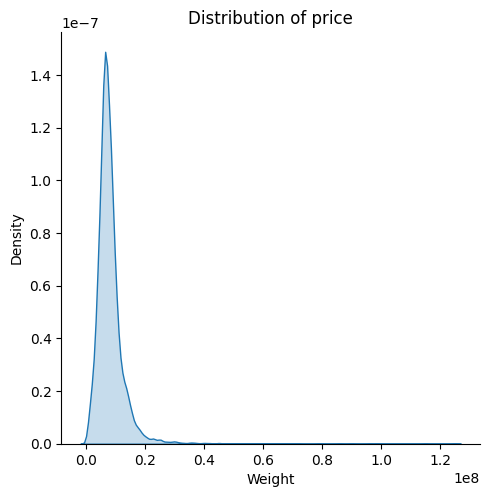

In [45]:
plt.figure(figsize=(10, 6))
sns.displot(data=df, x='price', kind='kde', fill=True, palette='mako')
plt.title('Distribution of price')
plt.xlabel('Weight')
plt.ylabel('Density')
plt.show();

In [46]:
print(
    f"Distribution price {check_normal(df['price'])[0]}, p-value {check_normal(df['price'])[1]}")

Distribution price not normal, p-value 0.0


In [47]:
df['price_log'] = np.log(df.price + 1)

<Figure size 1000x600 with 0 Axes>

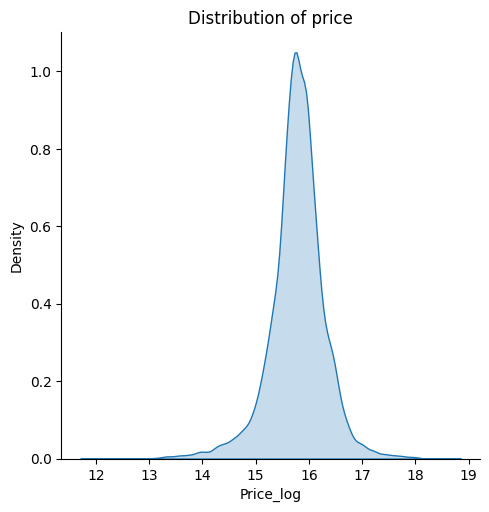

In [48]:
plt.figure(figsize=(10, 6))
sns.displot(data=df, x='price_log', kind='kde', fill=True, palette='mako')
plt.title('Distribution of price')
plt.xlabel('Price_log')
plt.ylabel('Density')
plt.show()

In [49]:
print(f"Distribution price_log {check_normal(df['price_log'])[0]}")

Distribution price_log not normal


**The distribution is not normal, but close to normal. Any of the prices can be used for prediction.**.

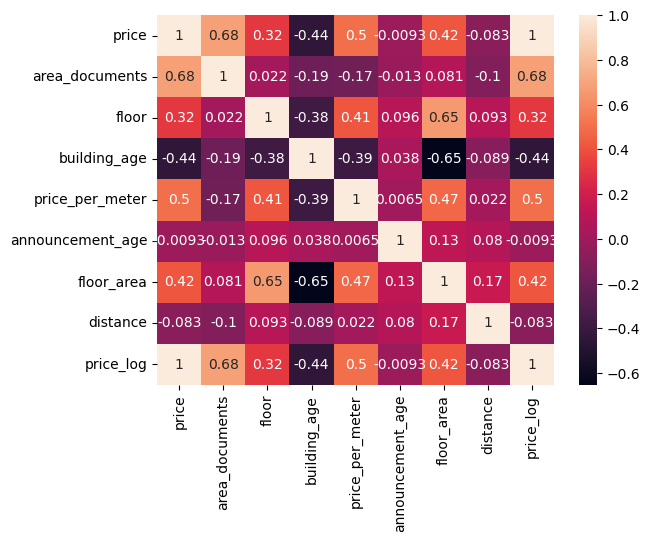

In [50]:
# Let's create a heat map for the numeric characters
sns.heatmap(df.drop(['year', 'lat', 'lon'], axis=1).corr(method='spearman', numeric_only=True),
            annot=True)
plt.show()

1) Correlation between **price** and other attributes:

 - **area_documents**: Correlation of 0.68, indicating that larger document area is associated with higher price.
 - **floor**: Correlation 0.32, indicating a moderate positive relationship between floor and price.
 - **floor_area**: Correlation 0.42 - higher floor area is also associated with higher price.
 - **building_age**: Negative correlation (-0.43), indicating that older buildings are associated with lower price.
- **distance**: Very weak correlation (-0.083), indicating a weak relationship between distance and price.
- **price_per_meter**: Correlation of 0.5, which is logical since price per square meter is closely related to total price.

2) Correlations between other attributes:
- **building_age** and **floor_area** have a fairly strong negative correlation (-0.72), which may indicate that older buildings have smaller square footage.
- Moderate negative correlation between **building_age** and **floor** (-0.51), which may indicate that older buildings have smaller floors.

In [51]:
# Create a heat map using categorical attributes

In [52]:
categorical_features = [
    'district_value',
    'address_value',
    'house_type_value',
    'apartment_type',
    'renovation',
    'balcony_loggia',
    'construction_status',
    'mortgage',
    'data',
    'city']

In [53]:
cramers_v_matrix = pd.DataFrame(
    index=categorical_features, columns=categorical_features)

# Calculate Cramér's V coefficients for all unique pairs of characteristics
for col1, col2 in combinations(categorical_features, 2):
    confusion_matrix = pd.crosstab(df[col1], df[col2])
    v = cramers_v(confusion_matrix)
    cramers_v_matrix.at[col1, col2] = v
    # Write to both cells of the symmetric matrix
    cramers_v_matrix.at[col2, col1] = v

In [54]:
cramers_v_matrix = cramers_v_matrix.astype(float)
cramers_v_matrix

,district_value,address_value,house_type_value,apartment_type,renovation,balcony_loggia,construction_status,mortgage,data,city
district_value,NaN,0.866914,0.447412,0.277243,0.387201,0.524644,0.679781,0.613986,0.429878,0.741936
address_value,0.866914,NaN,0.939543,0.749997,0.793579,0.911923,0.997494,0.948705,0.657678,0.859581
house_type_value,0.447412,0.939543,NaN,0.204357,0.401918,0.338093,0.767212,0.496071,0.495890,0.266091
apartment_type,0.277243,0.749997,0.204357,NaN,0.166240,0.210052,0.329157,0.162682,0.585700,0.277752
renovation,0.387201,0.793579,0.401918,0.166240,NaN,0.315430,0.862939,0.574528,0.551281,0.237915
balcony_loggia,0.524644,0.911923,0.338093,0.210052,0.315430,NaN,0.443520,0.493925,0.711420,0.150555
construction_status,0.679781,0.997494,0.767212,0.329157,0.862939,0.443520,NaN,0.560946,0.903081,0.435120
mortgage,0.613986,0.948705,0.496071,0.162682,0.574528,0.493925,0.560946,NaN,0.862399,0.247976
data,0.429878,0.657678,0.495890,0.585700,0.551281,0.711420,0.903081,0.862399,NaN,0.519025
city,0.741936,0.859581,0.266091,0.277752,0.237915,0.150555,0.435120,0.247976,0.519025,NaN


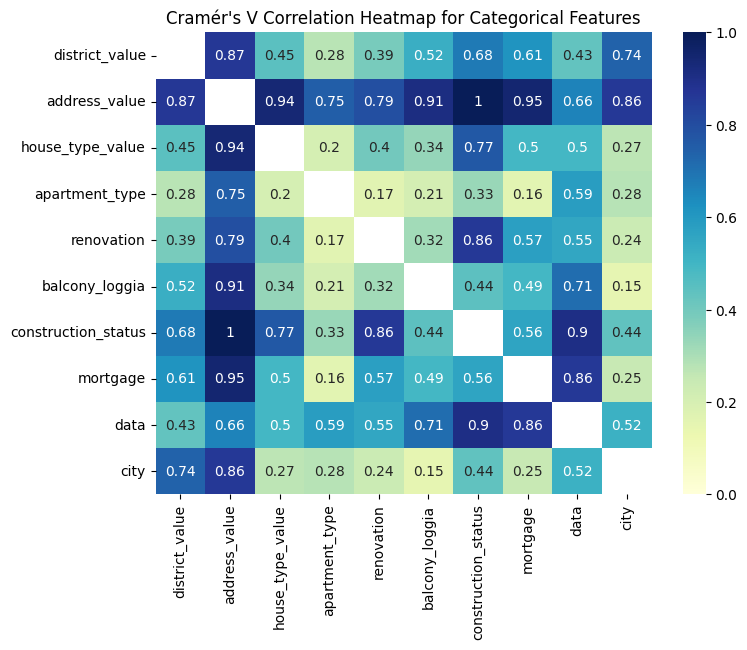

In [55]:
# Create a heat map using categorical attributes
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Cramér's V Correlation Heatmap for Categorical Features")
plt.show()

#### Strong correlation between some traits:

1. **address_value and district_value (0.87)**: This high correlation indicates that address and neighborhood are closely related. This is logical as addresses in certain neighborhoods may reflect the level of development and infrastructure.

2. **address_value and construction_status (1)**: Perfect correlation indicates that construction status is entirely determined by address. This is likely due to the fact that some neighborhoods (or certain addresses) may only have properties in certain stages of construction.

3. **house_type_value and address_value (0.85)**: House type is also highly correlated with address, indicating a relationship between certain types of buildings and specific addresses.

4. **mortgage and address_value (0.95)**: The high correlation between mortgage opportunity and address may indicate the dependence of mortgage offerings on location. For example, certain neighborhoods may offer more favorable mortgage terms.

5. **balcony_loggia and address_value (0.91)**: The presence of a balcony or loggia is also strongly associated with address, perhaps reflecting the characteristics of development in certain neighborhoods.

#### Average correlation between traits:

1. **renovation and address_value (0.79)**: Renovation is related to address, possibly reflecting certain renovation standards or styles in different neighborhoods.

2. **construction_status and district_value (0.68)**: Construction status is related to district, which is expected since different neighborhoods may have different stages of construction.

3. **city_kr and address_value (0.86)**: The relationship between city and address indicates that certain address features may be city-specific.

4. **mortgage and construction_status (0.5)**: The average correlation indicates that mortgage credit availability may depend in part on the construction stage of a property.

5. **mortgage and balcony_loggia (0.5)**: Mortgage credit availability may also depend on the presence of balcony or loggia, which may be related to buyers' preferences or banks' requirements.

6. **data and construction_status (0.9)**: High correlation with date may suggest that construction status is dependent on time factors.

#### Low correlation between some attributes:

1. **apartment_type and renovation (0.17)**: Apartment type is weakly correlated with renovation, which may indicate that these variables are independent.

2. **apartment_type and balcony_loggia (0.21)**: The weak correlation also suggests that apartment type has little effect on the presence of a balcony or loggia.

3. **city_kr and renovation (0.24)**: The correlation between city and renovation is also insignificant, which may suggest different renovation standards regardless of region.

#### Significant correlations regarding **hypothesis**:

1. **mortgage and construction_status (0.5)**: The average correlation with construction status may indicate a relationship between construction stage and mortgage availability.

2. **mortgage and address_value (0.95)**: High correlations with address may indicate that certain neighborhoods have more favorable mortgage terms.

#### Correlations related to **building status**:

1. **construction_status and data (0.9)**: The strong correlation between construction status and date may indicate the dependence of status on temporal factors such as due dates.

2. **construction_status and district_value (0.68)**: The relationship between construction status and district may indicate the specificity of construction in certain neighborhoods.


### 1) Prices vary from city to city.

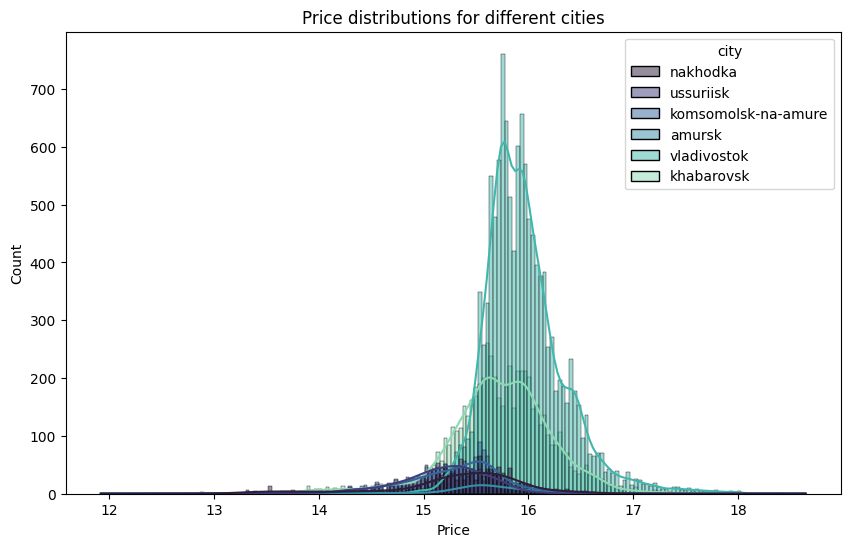

In [56]:
# Построение графика hist
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price_log', hue='city', kde=True, palette='mako')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price distributions for different cities')
plt.show()

<Axes: xlabel='price_log', ylabel='Density'>

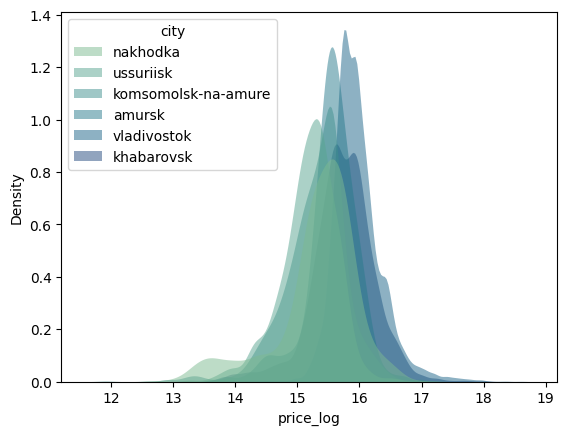

In [57]:
sns.kdeplot(
    data=df, x="price_log", hue="city",
    fill=True, common_norm=False, palette="crest",
    alpha=.5, linewidth=0,
)

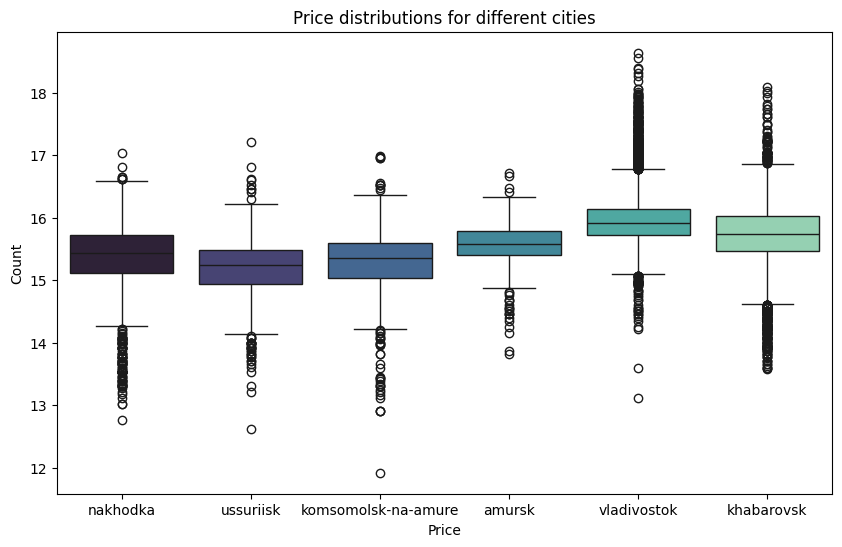

In [58]:
# Plotting the hist
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='price_log', x='city', palette='mako')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price distributions for different cities')
plt.show()

1. **Cities with higher prices**:
   - `vladivostok` and `khabarovsk` have the highest price density at 15-16 (in logarithms). These cities have the highest number of data, which can be seen in the high columns. This indicates that most of the properties in these cities have prices within this range.

2. **Cities with lower prices**:
   - Cities such as `nakhodka`, `ussuriisk`, `komsomolsk-na-amure` and `amursk` have lower density peaks, indicating smaller samples or lower prices overall. Their distributions are to the left (smaller logarithmic values of prices).

3. **Difference in density**:
   - `vladivostok' has the most pronounced distribution with the highest number of properties, possibly indicating a larger real estate market compared to other cities.
   - `Khabarovsk' also has a high peak, slightly lower than Vladivostok, but similar in distribution shape.

4. **Price distribution**:
   - All distributions have right-sided asymmetry - most objects have a price in the low range, while a smaller proportion of objects are found in the high range. This may indicate the presence of premium properties, but the number of properties is much smaller.

**Total**:
This chart shows that the cities of `vladivostok` and `khabarovsk` have a higher concentration of properties with relatively high prices, while in other cities the real estate market is likely to be smaller in volume and with lower prices.

### 2) Prices for apartments in buildings made of different materials vary

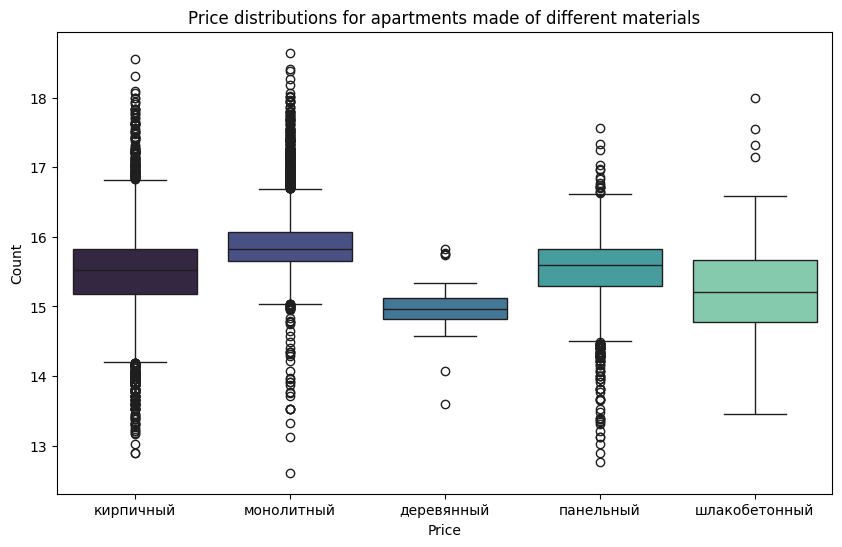

In [59]:
# Построение графика
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='price_log', x='house_type_value', palette='mako')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price distributions for apartments made of different materials')
plt.show()

1. **Brick House**:
   - Prices range from approximately 13 to 18 units.
   - The median price is in the neighborhood of 16 units.
   - A large number of outliers both above and below, indicating the presence of expensive and cheap apartments compared to the main distribution.

2. **Monolithic House**:
   - Prices are similar to brick houses, but the median is slightly higher (by about 16.5).
   - There are many outliers, especially at the bottom of the distribution, suggesting that there are lower prices in some cases.
   
3. **Wooden House**:
   - The smallest price range among all material types.
   - The median is around 14.5 units, making this the least expensive material.
   - There are a few outliers at the lower end.

4. **Panel House**:
   - The price range is slightly less than that of brick and monolithic homes.
   - The median price is around 15 units.
   - There are also outliers, especially in the lower part of the distribution, indicating the presence of cheap apartments.

5. **Slag concrete house**:
   - Prices have a narrower distribution than brick and monolithic houses, with a median of about 16 units.
   - Fewer outliers, but the distribution is more compressed.

#### Total:
- Brick and monolith homes have similar price ranges and distributions, making them the most expensive housing types.
- Wood homes have the lowest prices and narrowest price ranges, which may indicate more limited supply or lower quality housing.
- Panel and cinder block houses occupy an intermediate position, with median prices around 15-16 units.

### 3) Relationship between apartment price and area by building type

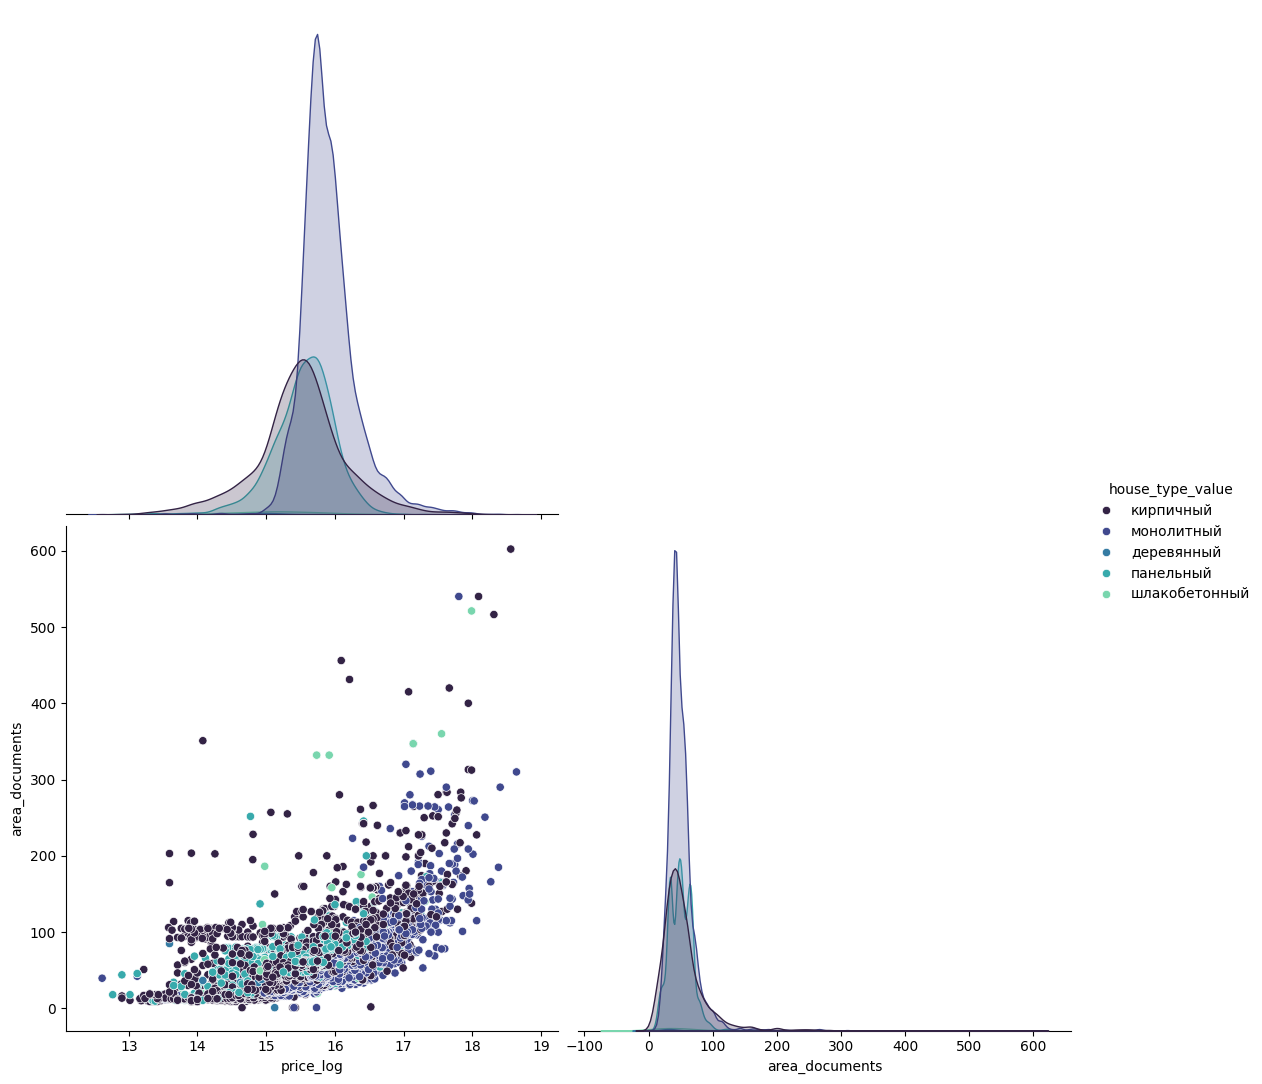

In [60]:
features = [
    'price_log', 'area_documents'
]

sns.pairplot(df, vars=features, height=5.5, aspect=1,
             hue='house_type_value', corner=True, palette='mako');

1. **Correlation between price and area**:
   - A positive correlation can be seen: the larger the area of the apartment, the higher the price. This is an expected correlation, since area is one of the main factors determining the price of an apartment.
   
2. **House Types**:
   - The colors of the dots in the diagram distinguish the types of houses: brick, monolithic, wooden, panel and cinder concrete.
   - **Brick** and **Monolithic** homes** (dark colors) occupy most of the chart, especially in the upper right corner where prices and square footage are high.
   - **Wooden** homes (light blue) and **panel** homes tend to be closer to the lower left corner, indicating smaller areas and lower prices compared to brick and monolithic homes.

3. **Distribution Diagrams**:
   - The histograms on the axes show the density distribution of price and area for all house types.
   - **Price axis**: the densest distribution (highest frequency) is found in the 14-17 unit range, with brick and monolithic homes dominating this category.
   - **On the area axis**: most apartments are around 100 square meters, with fewer apartments above 200 square meters. However, there are a few points well beyond 500 square meters, which may indicate the presence of luxury housing.

4. **Emissions**:
   - There are a few outliers (points far from the bulk of the data) in the chart, especially in the area of high floor area values (> 400 square meters), which probably corresponds to luxury or substandard apartments.

#### General conclusions:
- The price-area relationship is positively correlated, with brick and monolithic houses tending to have higher prices and larger areas.
- Wooden and panelized houses tend to be cheaper and smaller in area.
- The main price distribution is concentrated in the range of 14-17 units, and the area of most apartments is around 100 sq. m.

### 4) Цены в различных районах одного города отличаются

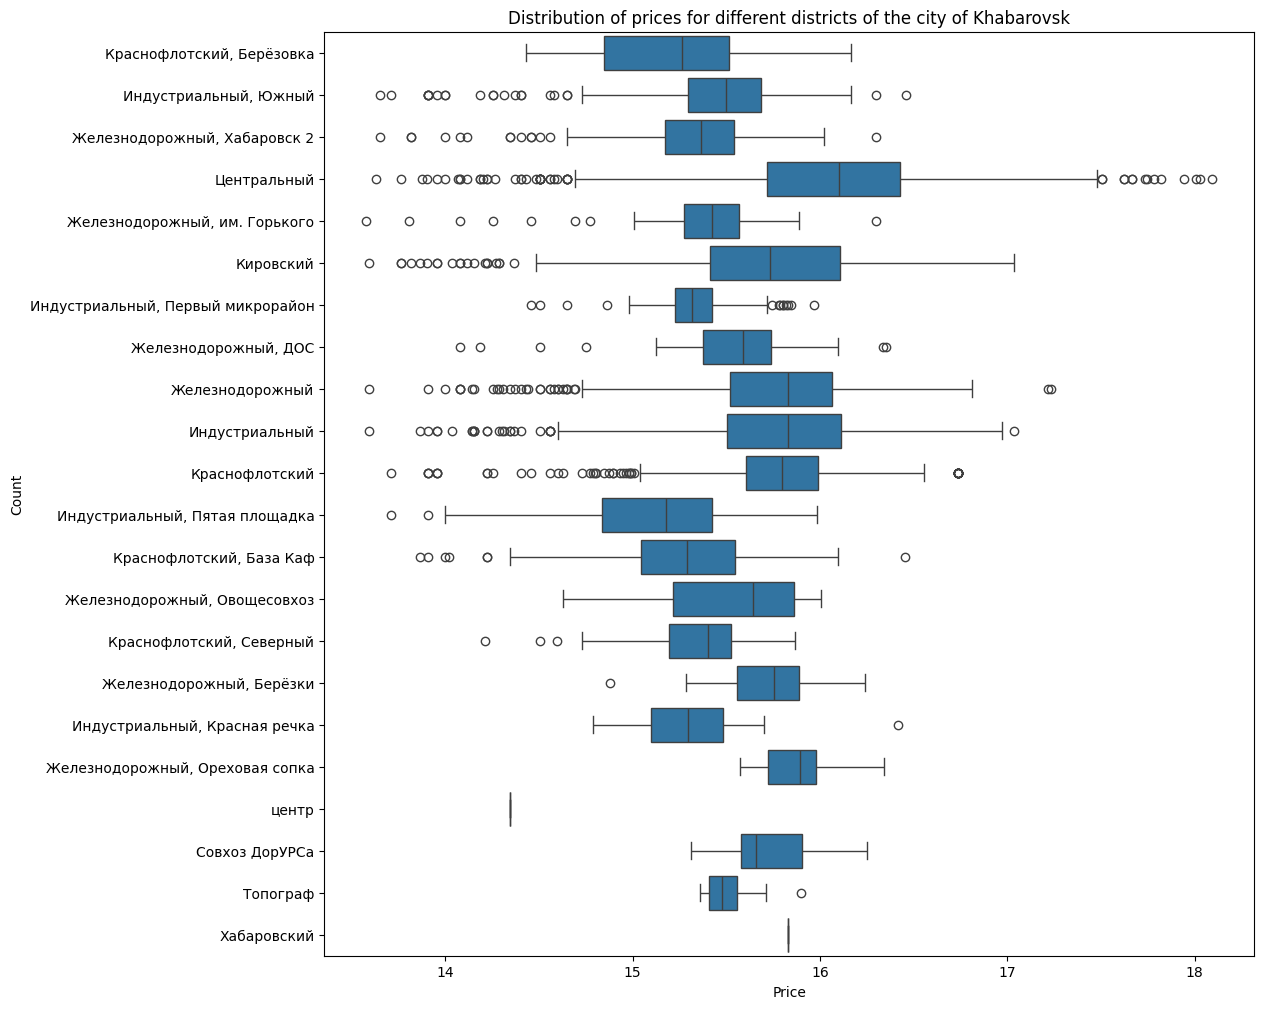

In [61]:
# Let's take Khabarovsk as an example.
df_filtered_khv = df[(df['city'] == 'khabarovsk')][[
    'price_log', 'district_value']]

plt.figure(figsize=(12, 12))
sns.boxplot(data=df_filtered_khv, x='price_log', y='district_value')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of prices for different districts of the city of Khabarovsk')
plt.show()

#### 1. **Median Values**.
   - **Central neighborhood**: This neighborhood has the highest median value, indicating more expensive real estate. The median stands out above the rest, making this neighborhood the most expensive on the chart.
   - **Krasnoflotsky, Beryozovka** and **Industrial, South**: These neighborhoods also have high medians, but are lower than Centralny. They are at the upper end of the price range and can be considered premium, but not at the level of the Center.
   - **Industrial, Fifth Place**, **Zheleznodorozhny, DOS**, **Krasnoflotsky, Severny**: Located in the middle range of median values, indicating a balance of accessibility and attractiveness.
   - **Khabarovsky**, **Sovkhoz Dorursa**, and **Topograph**: Have the lowest median values, indicating relatively low housing costs in these neighborhoods.

#### 2. **Width of distribution (interquartile range)**
   - **Central neighborhood**: The wide distribution indicates a variety of prices in this neighborhood, likely depending on the specific location and housing type. High prices for individual properties may be associated with more upscale addresses or newer developments.
   - **Zheleznodorozhny, Khabarovsk 2** and **Industrial, Yuzhny**: These neighborhoods also have a wide distribution, suggesting variation in prices and the availability of both expensive and more affordable properties.
   - **Industrial, Fifth Place** and **Railroad, DOS**: Medium width of distribution, indicating moderate price variation, possibly depending on the condition of housing and infrastructure.
   - **Khabarovsky** and **Topograph**: Narrow distribution indicates a more homogeneous price structure, probably dominated by cheaper housing.

#### 3. **Districts**.
   - **Central District** and **Krasnoflotsky, Beryozovka**: Significant emissions can be seen to the right of the distribution, indicating the presence of very expensive properties. These objects may represent luxury housing, which is very different in price from the average level in the neighborhood.
   - **Industrial, Yuzhny** and **Zheleznodorozhny, Khabarovsk 2**: Also have some outliers, which may be due to the high prices of unique properties in these neighborhoods.
   - **Low-price districts** (e.g. **Sovkhoz DorURSa** and **Topograph**) have less emissions, indicating more stable and low prices, without sharply distinguished elite objects.

#### Total:
- **Central District** is characterized by high prices with a wide distribution and many emissions, making it the main price driver in the city.
- **Industrial, South** and **Krasnoflotsky, Beryozovka** also have high medians and wide distribution, indicating price diversity and high demand.
- Lower prices and narrow distribution in neighborhoods like **Topograph** and **Sovkhoz DorURSa** make them attractive to buyers on a tight budget.
- Different neighborhoods can vary significantly in both average cost and price range.


#### 5) The price decreases with the age of the building.

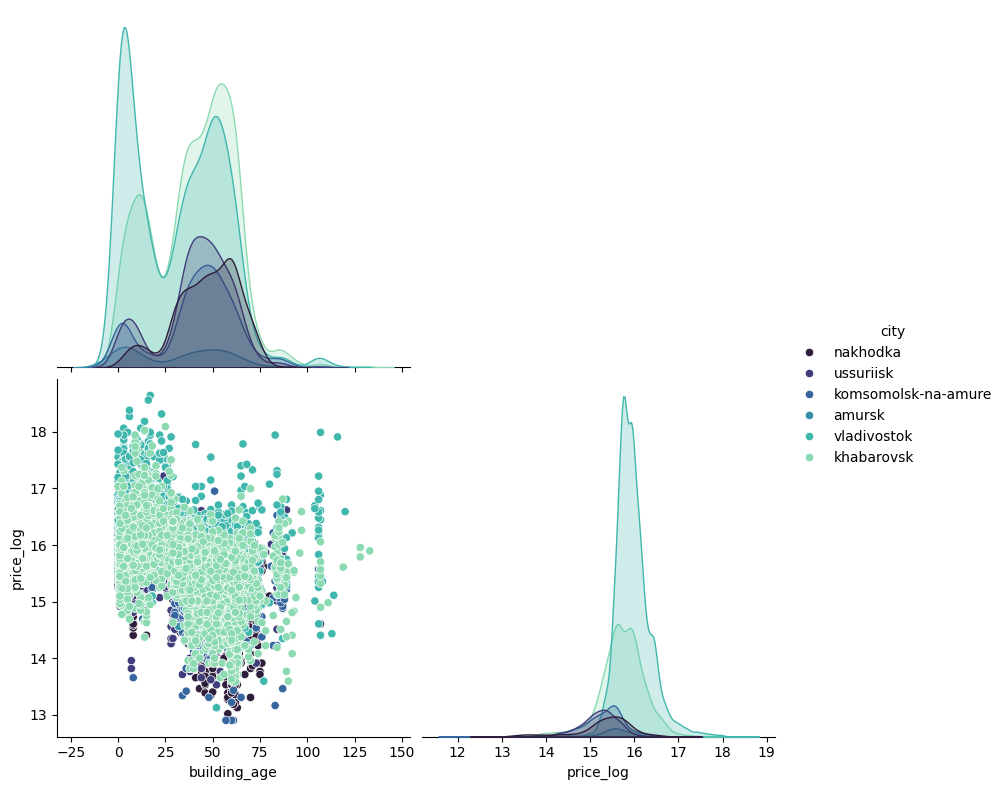

In [62]:
features = [
    'building_age', 'price_log'
]

sns.pairplot(df, vars=features, height=4, aspect=1,
             hue='city', corner=True, palette='mako');

#### 1. **The relationship between building age and price**:
   - It can be seen that for most properties the price decreases as the age of the building increases. This can be seen by how points with higher building age (especially above 50 years) are located in the area of lower prices (13-15 on a logarithmic scale).
   - For new buildings (0-25 years), prices are noticeably higher (15 to 17 on the logarithmic scale), especially in cities such as **Vladivostok** and **Khabarovsk**, where prices for new buildings are kept at a high level.

#### 2. **Cities with low prices and old buildings**:
   - **Nakhodka**, **Komsomolsk-on-Amur** and **Ussuriysk** show lower prices (13-15) for buildings 50 years and older. This may indicate that in these cities older buildings have a significantly lower value compared to newer buildings.

#### 3. **Distribution density for different ages of buildings**:
   - The distribution shows that the highest data density is observed for buildings aged 0 to 50 years, especially in the cities of **Khabarovsk** and **Vladivostok** where prices are relatively high. For older buildings the data density decreases noticeably, indicating a smaller number of offers of such real estate objects.

#### Total:
Overall, we can conclude that real estate price does tend to decrease with increasing age of the building. Older buildings (50+ years old) tend to be cheaper, while newer properties have higher prices, especially in large cities such as **Vladivostok** and **Khabarovsk**.

### 6) Mortgage availability has an impact on price

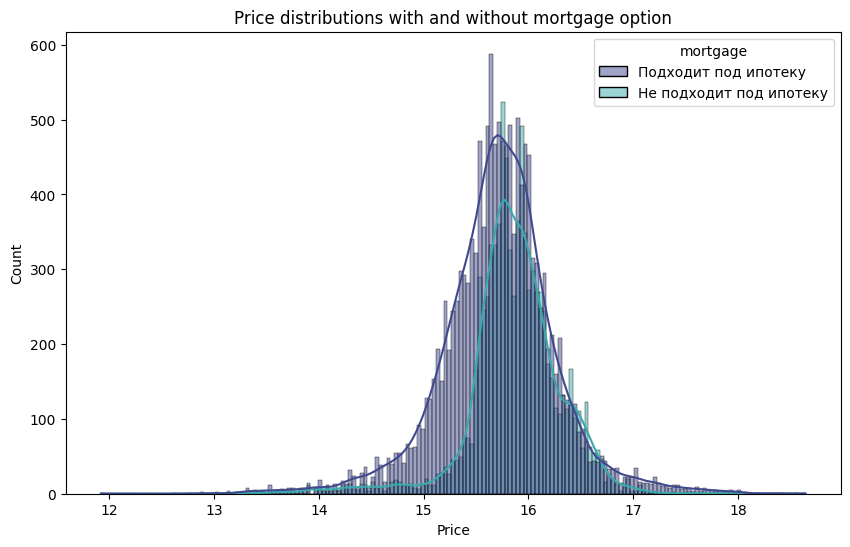

In [63]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price_log', hue='mortgage', kde=True, palette='mako')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price distributions with and without mortgage option')
plt.show()

#### 1. **Main body of data**:
   - Most properties with and without mortgage options are concentrated in the price range **from 15 to 16** on a logarithmic scale (on the Price axis). These are the most frequent prices for both categories.

#### 2. **Distribution for properties **appropriate for mortgages**:
   - Mortgage-eligible properties (purple columns) make up a significant portion of the data. They have a more pronounced peak in the price range around **15.5**. This means that the majority of mortgage-eligible properties in the real estate market are concentrated in this price segment.

#### 3. **Distribution for properties that are **not suitable for mortgages**:
   - Properties that are **not mortgage eligible** (blue columns) have a more even distribution with a less pronounced peak in the **14 to 16** price range. The peak is just below that of properties with a mortgage, around **15.2**.

#### 4. **Tails of distributions**:
   - Properties with high prices (above 16) are also present in both the mortgage-eligible and non-mortgage-eligible categories, but in smaller numbers. The tail of the distribution is slightly more extended for mortgage-eligible properties.

#### Total:
Prices for mortgage-eligible properties have a more pronounced concentration around **15.5**, which may indicate that these are the properties that are popular for mortgage deals. The objects not suitable for mortgage have a more even distribution of prices with a slight shift towards lower values.

### 7) Prices for different types of apartments have different distributions

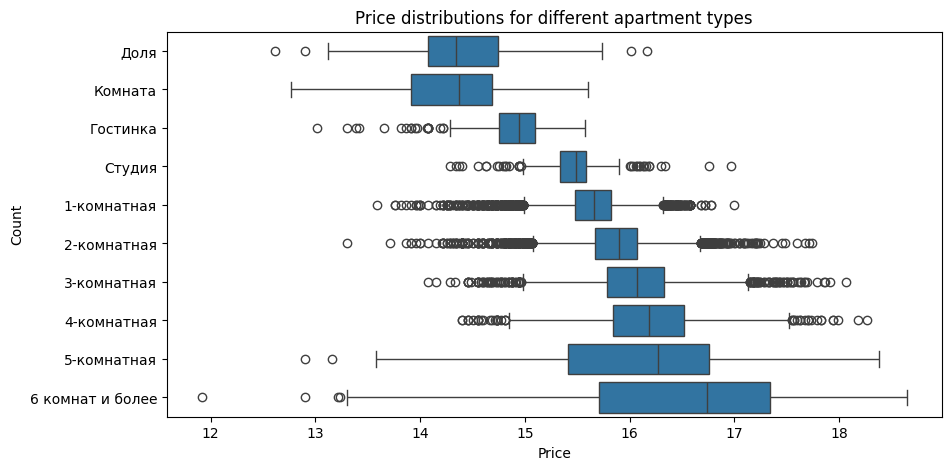

In [64]:
# Построение графика
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='price_log', y='apartment_type')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price distributions for different apartment types')
plt.show()

1. **Share, Room, Guest Room and Studio**:
   - These types of properties are in the lower price range. Average and median values for them are lower compared to full-fledged apartments.
   - The price range is relatively narrow, especially for the Share and Room categories, indicating less price variation. 
   - The greatest price variation is observed for studios, which may be explained by differences in the size and quality of such properties.

2. **1-room apartment**:
   - This category shows slightly higher price values than studios, but is still in a relatively affordable price range.
   - Prices also vary quite widely, which can be attributed to the variety of locations and condition of such properties.

3. **2-room apartment**:
   - The median value for this category is higher than for 1-bedroom apartments, which is expected given the larger square footage and functionality.
   - The price range is also widening, especially towards the upper end of the range, which may indicate a higher buyer interest in or demand for 2-room apartments.

4. **3-room apartment and 4-room apartment**:
   - These types have higher median price values and greater spread than apartments with fewer rooms.
   - The price spread in 4-bedroom apartments is particularly significant, which may indicate differences in layout and location, including options with high premium prices.

5. **5-room apartment and 6-room apartment or more**:
   - These categories are in the upper price range. 
   - The chart shows a large price spread for multi-room apartments, which may be due to unique properties such as large square footage, location in high-end neighborhoods, or the presence of premium features (panoramic views, designer renovations).
   - Median values are around 16 and above on the logarithm scale, indicating significant differences from more budget-friendly options.

### Total
- **Trend of prices increasing with the number of rooms**: Apartment prices increase with the number of rooms, which is logical given the increased square footage and generally better location of such properties.
- **More variability for multi-room apartments**: Apartments with more rooms show the greatest variability in price, which may be due to their unique characteristics and status in the market.
- **Affordable Categories (Share, Room, Guest Room)**: These properties have the lowest median prices and low price variation, which may speak to a target audience interested in affordable housing options.

### 9) Floor of apartment affects price

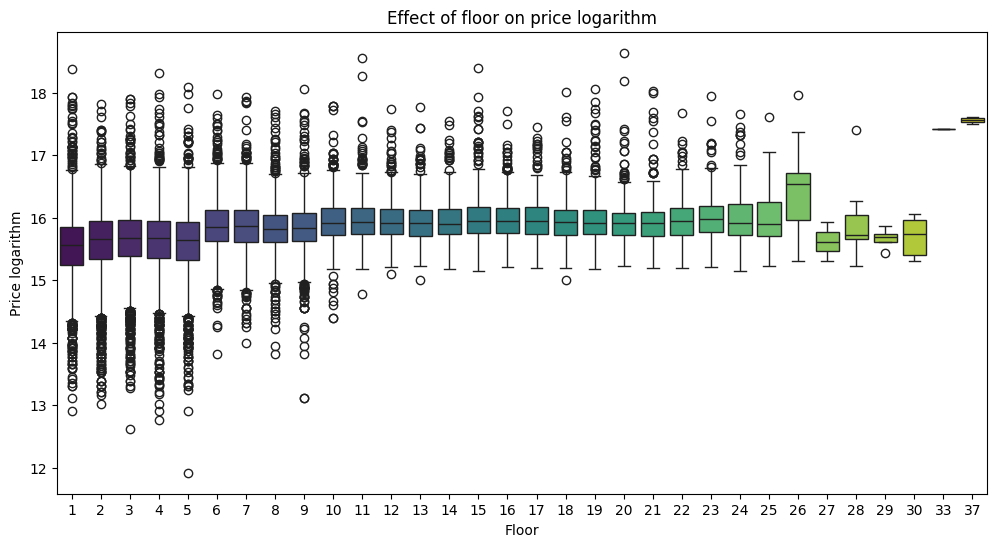

In [65]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='floor', y='price_log', palette='viridis')
plt.xlabel('Floor')
plt.ylabel('Price logarithm')
plt.title('Effect of floor on price logarithm')
plt.show()

The chart shows the effect of floor on the logarithm of apartment prices. The main observations are:

1. **First floors (1-4)**: The logarithm of price for the first floors is below average, with a large variation in prices. This may be due to the fact that apartments on first floors tend to be less popular due to noise, lack of privacy and other factors.

2. **Middle floors (5-18)**: Here, the logarithm of price is more stable and varies over a relatively narrow range. This confirms that middle floors are generally more sought after and are often considered optimal in terms of convenience and views. Prices on such floors are more stable and have fewer outliers.

3. **Higher floors (19-30)**: There is an increase in the logarithm of price for some of the higher floors, especially on floors 25 and above, which may be due to the improved views from windows and the prestige of the higher floors.

4. **Very high floors (above 30)**: There is a strong variation in the logarithm of price, which also depends on the unique features of these floors, such as exclusivity or the presence of penthouses. On the 37th floor, the logarithm of the price is higher and less variable, which may indicate the high value and exclusivity of the apartments.

5. **Emissions**: Emissions are present on different floors, but they are more prominent on the first and middle floors. This may indicate a wide range of prices depending on the features of specific apartments.

### Total
Overall, the chart shows that floor has an impact on apartment prices: apartments on first floors cost less than apartments on middle and higher floors, where prices are more stable.

### 10) Housing prices of different eras have different distributions.

Split into three eras:
- '0-25' - New Buildings (0-25 years old)
- '25-80' - Middle-aged buildings (25-80 years old)
- '80+' - Older buildings (80+ years)

In [66]:
df['age_bin'] = pd.cut(df['building_age'], bins=[
                       0, 25, 80, float('inf')], labels=['0-25', '25-80', '80+'])

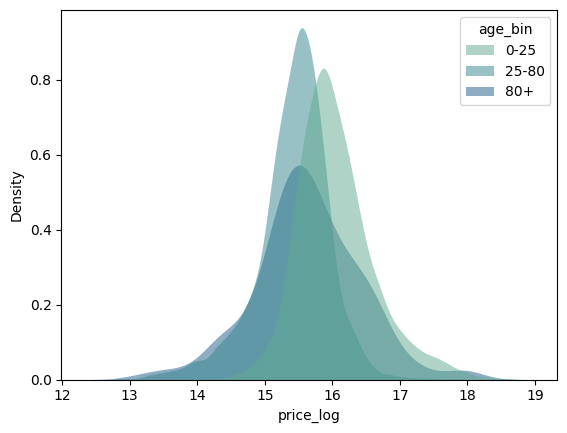

In [67]:
sns.kdeplot(
    data=df, x="price_log", hue="age_bin",
    fill=True, common_norm=False, palette="crest",
    alpha=.5, linewidth=0,
);

1. **New buildings (0-25 years old)**:
   - This group has the highest median value, indicating higher prices for apartments in new buildings.
   - The peak of the distribution for this group is shifted to the right compared to the other age categories, indicating higher price values.
   - The distribution is relatively narrow, indicating less variation in prices in this group compared to older buildings. This may indicate more stable prices for apartments in new buildings.

2. **Middle-aged buildings (25-80 years old)**:
   - The peak of the distribution is shifted slightly to the left compared to new buildings, indicating that apartment prices in these buildings tend to be lower.
   - The width of the distribution is slightly larger than for new buildings, indicating greater variability in prices.

3. **Older buildings (80+ years old)**:
   - For this group, the peak of the distribution is even further to the left than for new and middle-aged buildings, indicating the lowest median price values.
   - The distribution is wide, indicating a high variability in prices. This may be due to differences in the quality of older buildings: some may be historic or in prestigious neighborhoods, while others may be less attractive to buyers.

### Total
- **Price Decline Trend**: As the age of the building increases, apartment prices tend to decrease. This may be due to building deterioration, less modern floor plans, or decreasing appeal to buyers.
- **Less variability for new buildings**: Apartments in new buildings (0-25 years old) have a narrower distribution, which may indicate more standard pricing in the market for new properties.
- **Older buildings with high price variability**: The segment of buildings over 80 years old shows high variability. This may indicate a significant variation in the qualities of such buildings, for example between historic and less well-maintained buildings.

### 11) Different apartments are priced according to the following distribution

In [68]:
df['floor_bin'] = pd.cut(df['floor'], bins=[0, 5, 9, 25, float('inf')], labels=[
                         '0-5', '6-9', '10-25', '25+'])

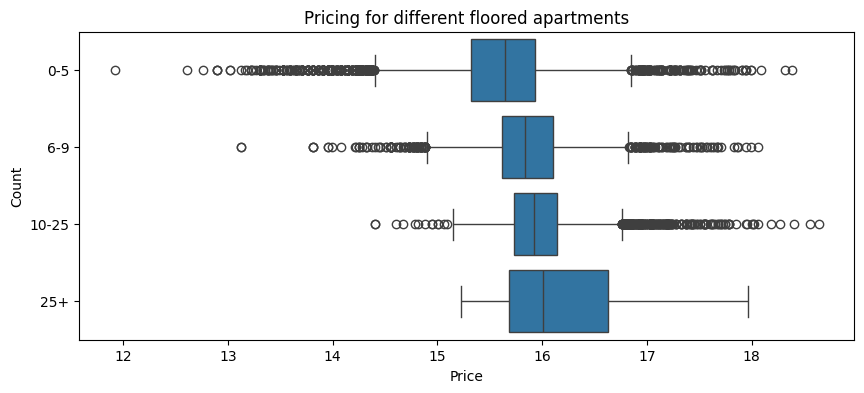

In [69]:
# Построение графика
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='price_log', y='floor_bin')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Pricing for different floored apartments')
plt.show()

1. **Low floors (0-5)**:
   - The underlying price distribution for these floors is quite broad, indicating considerable price diversity.
   - Outliers are present, both towards lower and higher values, indicating the presence of both inexpensive and expensive apartments on these floors.

2. **Middle floors (6-9)**:
   - The median value is slightly higher than the 0-5 category and the distribution is narrower.
   - Fewer outliers are observed, which may suggest greater homogeneity in the prices of apartments on these floors.

3. **High floors (10-25)**:
   - The median for this category continues to increase, which may indicate a trend of higher prices for higher floors.
   - The width of the distribution is also getting larger, which shows the diversity of prices on these floors. There are some outliers toward higher prices.

4. **Very High Floors (25+)**:
   - The median value is the highest among all categories, which may indicate the premium nature of apartments on these floors.
   - The distribution is wider than the other categories and there are outliers towards low and high prices.
   - This category may include luxury apartments or apartments with special features such as panoramic views, which may explain the higher prices.

### Total
- There is a tendency for the median price to increase with the number of floors, which may indicate a preference for apartments on higher floors, or the presence of additional amenities in such apartments.
- Higher floors (10-25 and 25+) have a wide variation in price, which may indicate different levels of quality or additional amenities available on these floors.
- Lower and middle floors are more stable in terms of prices, with fewer outliers, making them more homogeneous.

## Overall conclusion:
The dataset contains well-structured attributes that can be effectively used for a predictive model of real estate prices. The attributes are interrelated, which makes it possible to build a quality model.

In [70]:
# save to file
df.to_csv("data/df_eda.csv", index=True)